In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
merged_df = pd.read_csv('merged_df.csv')


C:\Users\micha\AppData\Local\Temp\ipykernel_26180\1179206518.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


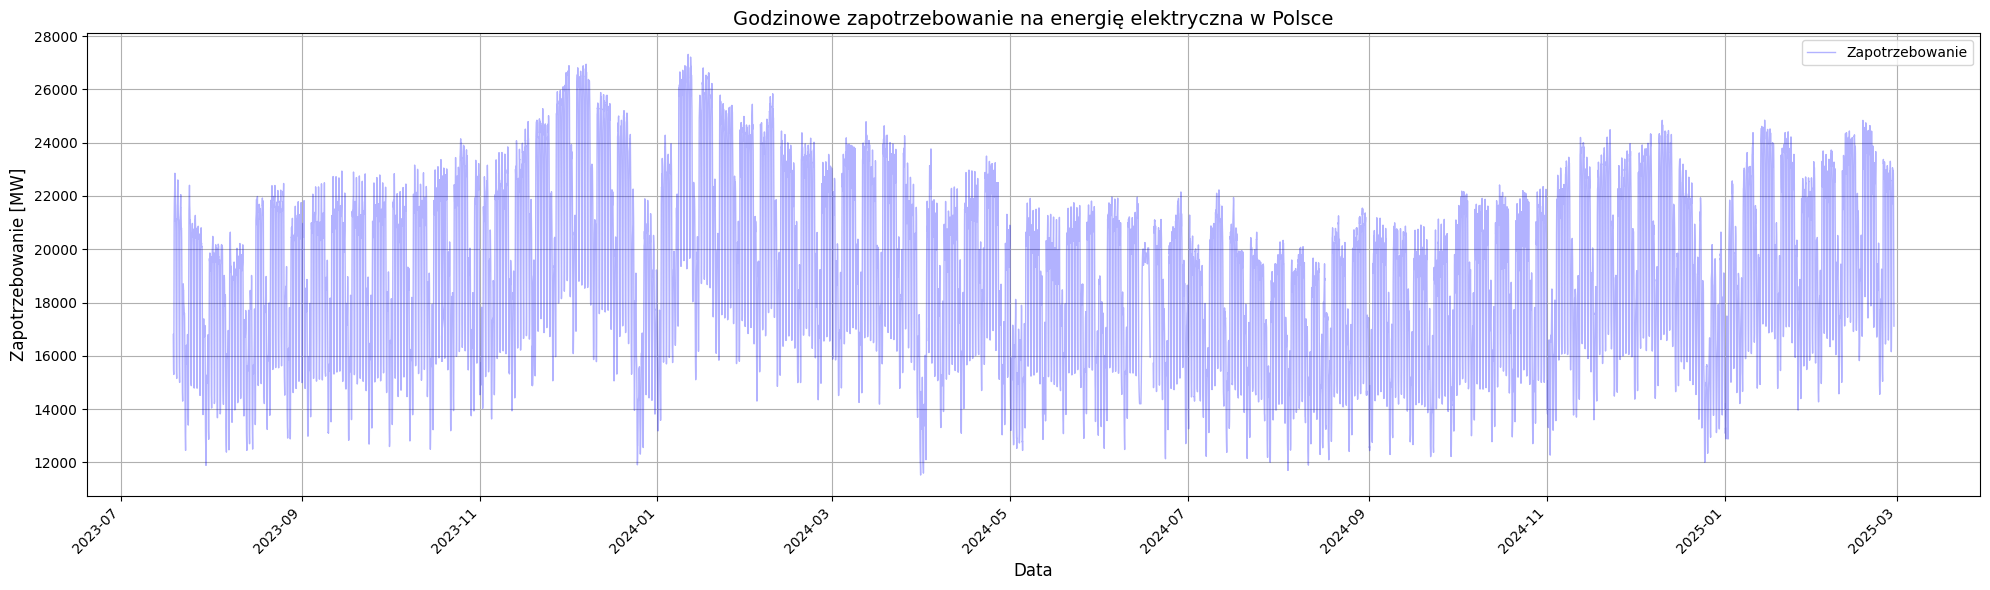

In [76]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(figsize=(20, 6))  # to jest właściwy sposób

merged_df.plot(x='Data', y='value', alpha=0.3, color='b',
               label='Zapotrzebowanie', linewidth=1, ax=ax)  # przekazujemy oś!
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Zapotrzebowanie [MW]', fontsize=12)
ax.grid(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Godzinowe zapotrzebowanie na energię elektryczna w Polsce', fontsize=14)

plt.tight_layout()  # opcjonalnie, żeby etykiety się zmieściły
plt.show()

In [ ]:
merged_df_d = merged_df
merged_df_d['Data'] = pd.to_datetime(merged_df_d['Data'])
merged_df_d['Day'] = merged_df_d['Data'].dt.date


In [62]:
merged_df['Dzień tygodnia'] = merged_df['Data'].dt.day_name()

C:\Users\micha\AppData\Local\Temp\ipykernel_26180\4190534859.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


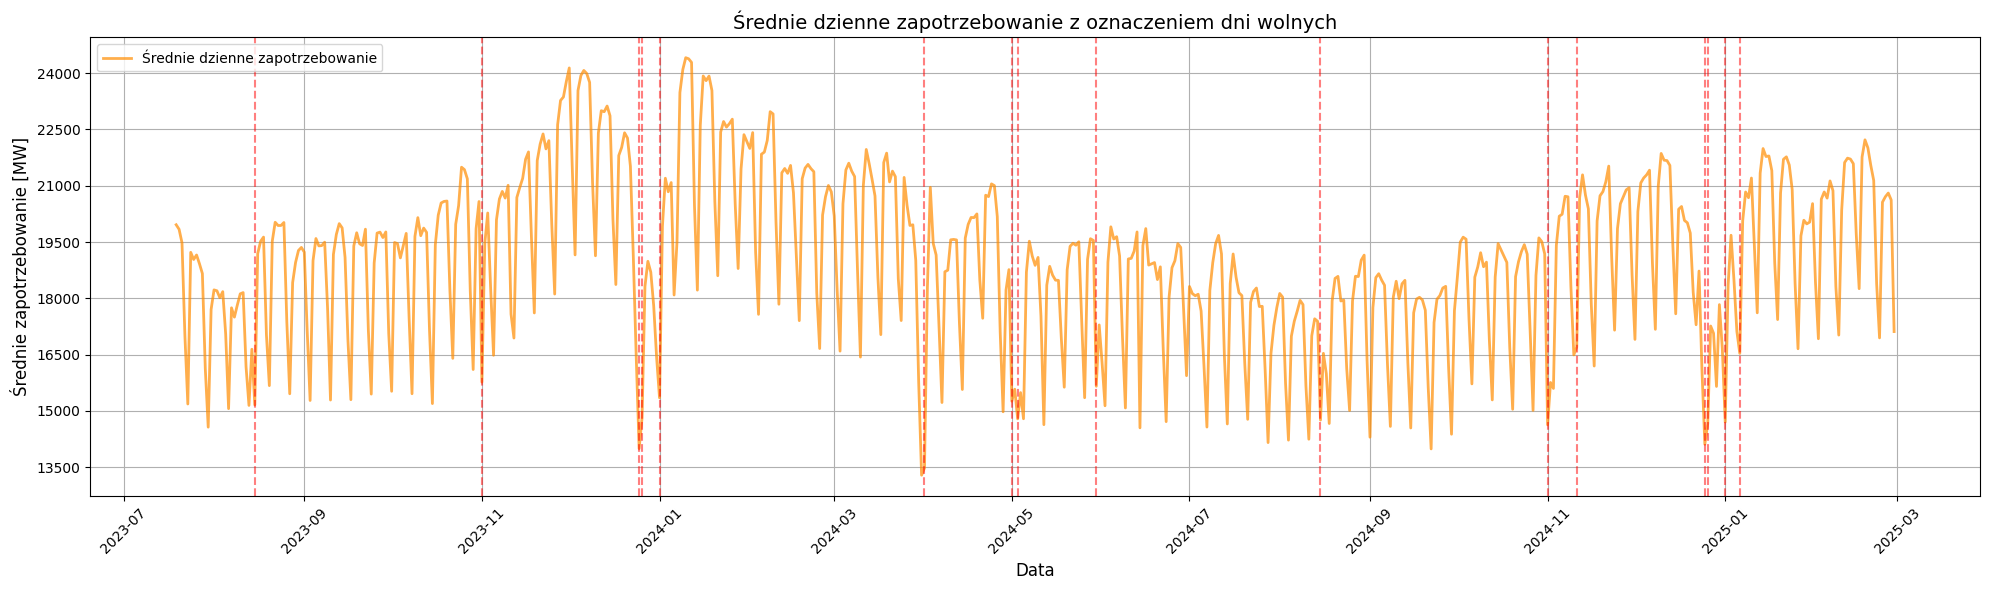

In [77]:
# Obliczamy średnią dzienną
daily_avg = merged_df_d.groupby('Day')['value'].mean().reset_index()

# Znajdź okresy, w których "Dzień wolny" wynosi 1
free_days = merged_df[(merged_df['Dzień wolny'] == 1) & (~merged_df['Dzień tygodnia'].isin(['Saturday', 'Sunday']))]['Day'].unique()

# Tworzymy wykres
fig, ax = plt.subplots(figsize=(20, 6))
daily_avg.plot(x='Day', y='value', kind='line', ax=ax,
               alpha=0.7, color='darkorange', label='Średnie dzienne zapotrzebowanie', linewidth=2)

# Dodajemy poziome linie dla dni wolnych
for day in free_days:
    ax.axvline(pd.to_datetime(day), color='red', linestyle='--', alpha=0.5, label='Dzień wolny')

# Oś x i y
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Średnie zapotrzebowanie [MW]', fontsize=12)
ax.grid(True)
ax.set_title('Średnie dzienne zapotrzebowanie z oznaczeniem dni wolnych', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))

plt.tight_layout()
plt.show()

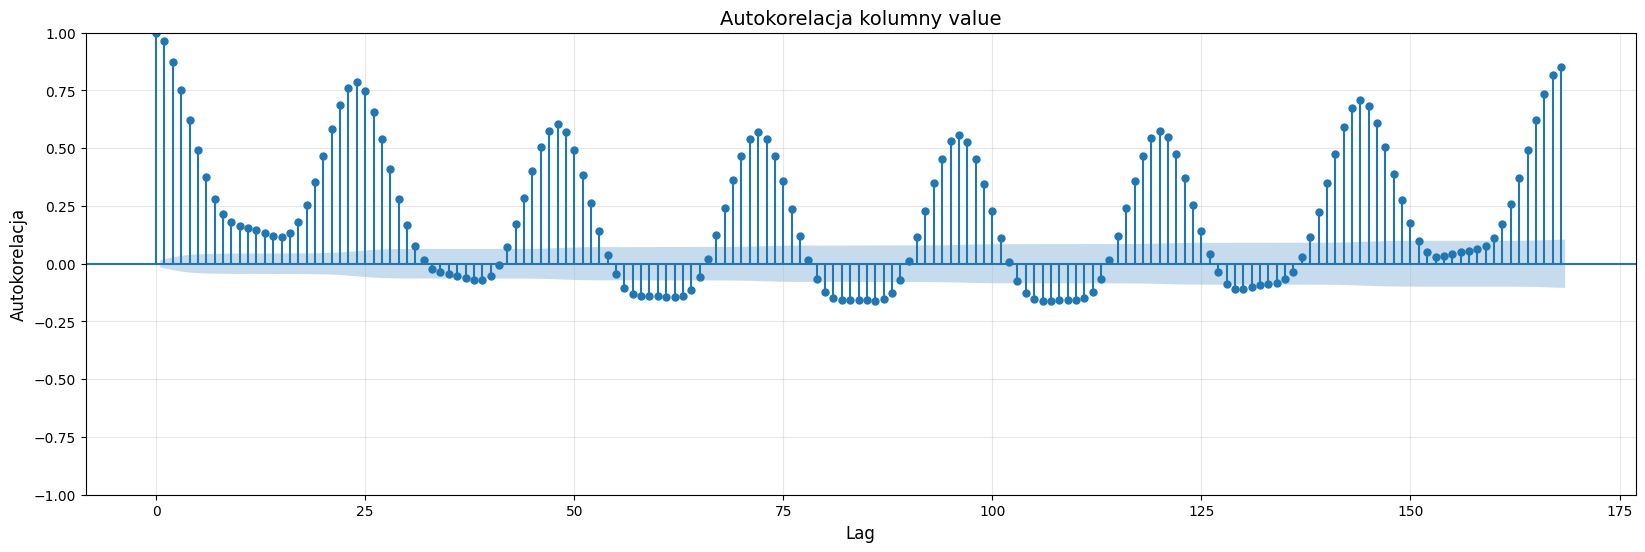

In [ ]:

# Wykres autokorelacji
fig, ax = plt.subplots(figsize=(20, 6))
plot_acf(merged_df['value'].dropna(), lags=24*7, ax=ax)
plt.title('Autokorelacja zapotrzebowania', fontsize=14)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autokorelacja', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

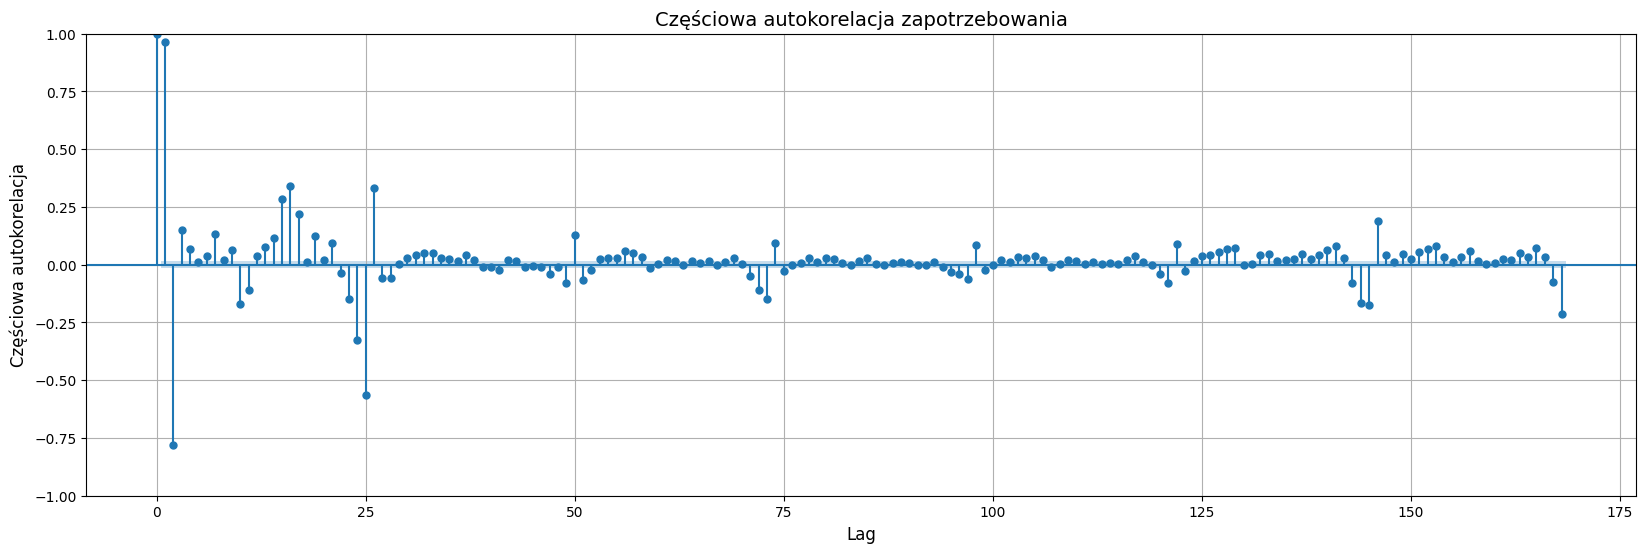

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Oblicz częściową korelację między 'value' a 'forecast', kontrolując 'Temperatura'

# Rysujemy PACF
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(merged_df['value'], lags=7*24, method='ywm',ax=ax)  # 'ywm' = Yule-Walker mod
plt.title("Częściowa autokorelacja zapotrzebowania", fontsize=14)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Częściowa autokorelacja', fontsize=12)
ax.grid(True)
plt.show() 

P = 7

### Decomposition

In [3]:
series = pd.Series(merged_df["value"][:-24*60], index=merged_df.index[:-24*60])

In [4]:
decomposition = seasonal_decompose(series, model='additive', period=24*7)

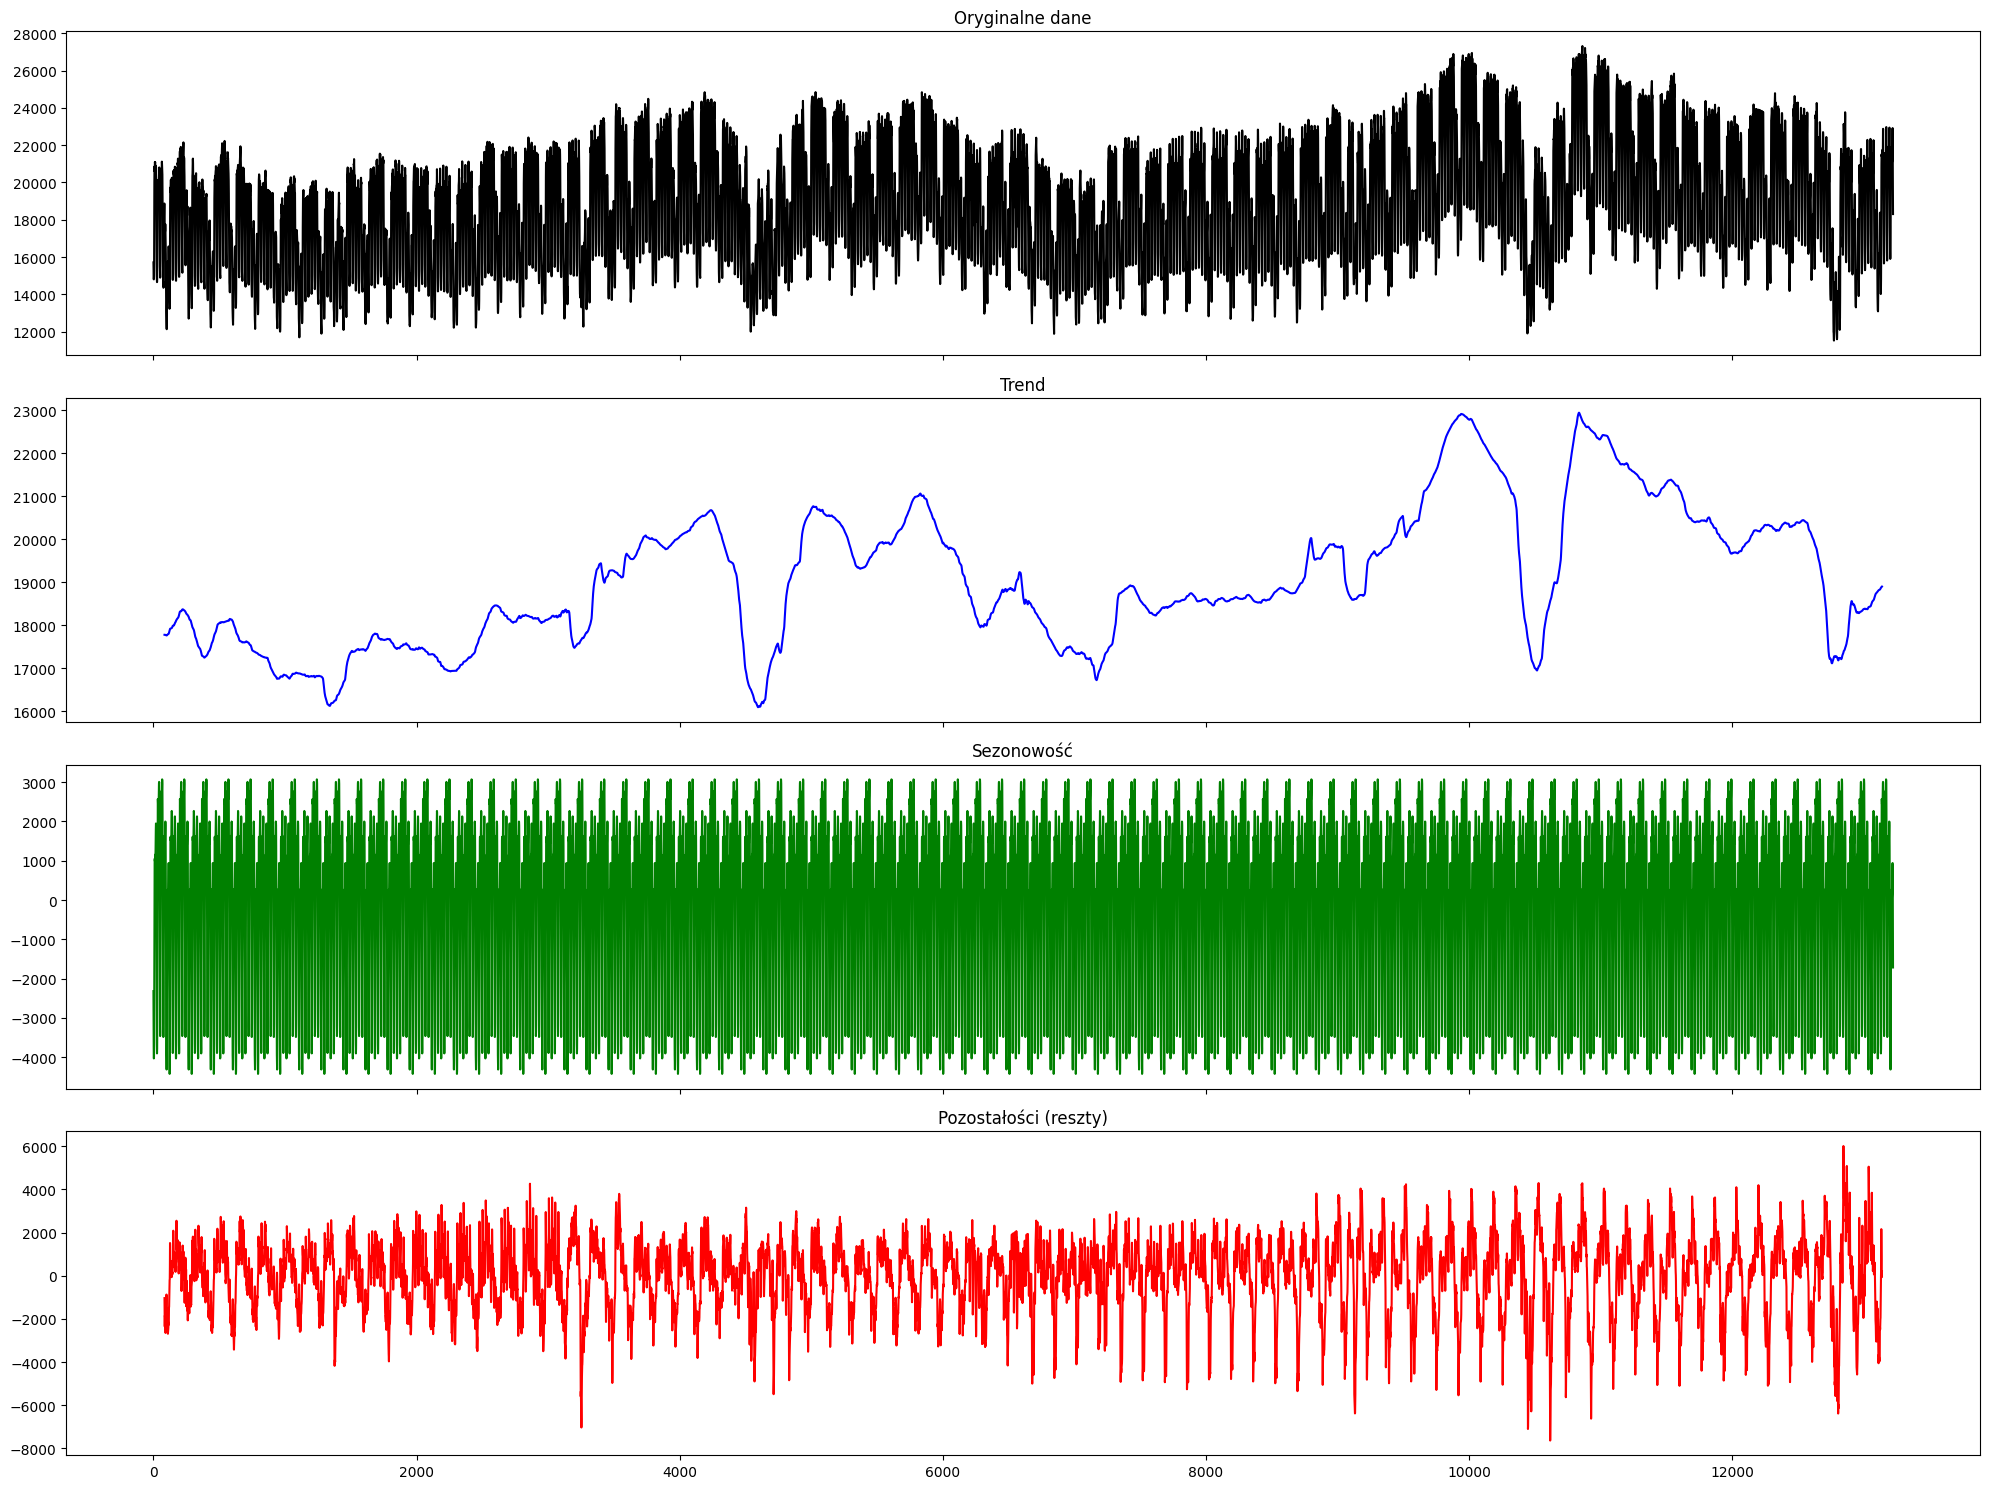

In [46]:
# Wykres wyników dekompozycji
fig, axes = plt.subplots(4, 1, figsize=(20, 15), sharex=True)
series.plot(ax=axes[0], title='Oryginalne dane', color='black')
decomposition.trend.plot(ax=axes[1], title='Trend', color='blue')
decomposition.seasonal.plot(ax=axes[2], title='Sezonowość', color='green')
decomposition.resid.plot(ax=axes[3], title='Pozostałości (reszty)', color='red')
plt.tight_layout()
plt.show()


C:\Users\micha\AppData\Local\Temp\ipykernel_31568\2992337105.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()
C:\Users\micha\AppData\Local\Temp\ipykernel_31568\2992337105.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[5].legend()


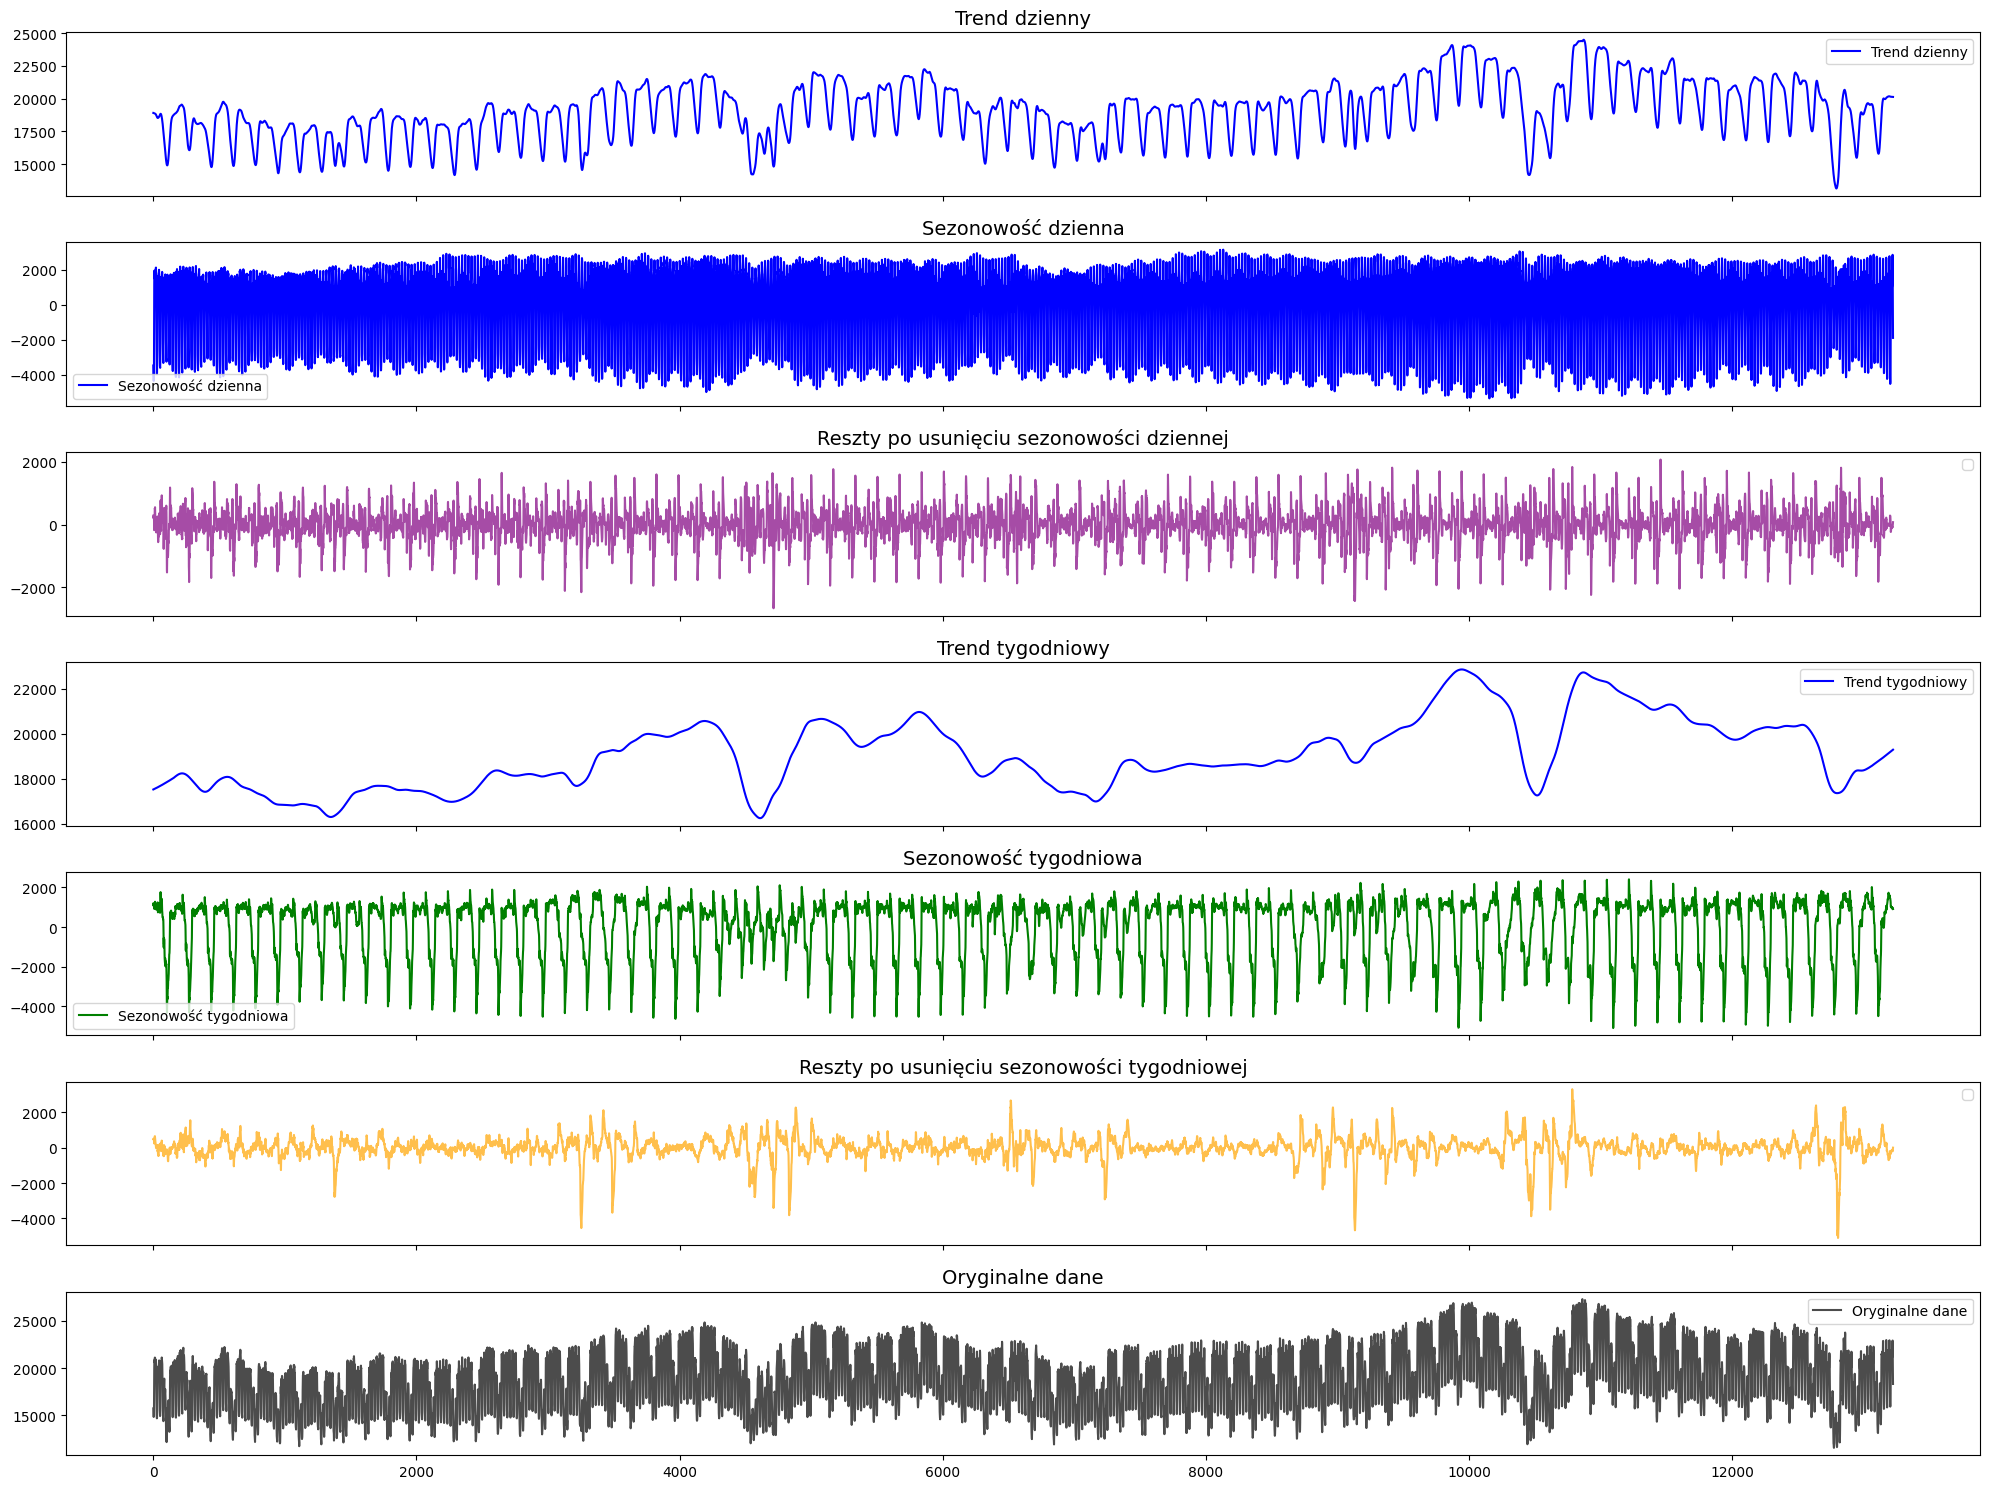

In [5]:
from statsmodels.tsa.seasonal import STL

# 1. Sezonowość dzienna (np. 24 godziny)
stl1 = STL(merged_df["value"][:-24*60], period=24)
res1 = stl1.fit()
detrended1 = merged_df["value"][:-24*60] - res1.seasonal

# 2. Sezonowość tygodniowa (168 godzin)
stl2 = STL(detrended1, period=168)
res2 = stl2.fit()

# Wykres wyników STL
fig, axes = plt.subplots(7, 1, figsize=(20, 15), sharex=True)

# Trend dzienna
axes[0].plot(res1.trend, label='Trend dzienny', color='blue')
axes[0].set_title('Trend dzienny', fontsize=14)
axes[0].legend()

# Sezonowość dzienna
axes[1].plot(res1.seasonal, label='Sezonowość dzienna', color='blue')
axes[1].set_title('Sezonowość dzienna', fontsize=14)
axes[1].legend()

# Reszty po usunięciu sezonowości dziennej
axes[2].plot(res1.resid, color='purple', alpha=0.7)
axes[2].set_title('Reszty po usunięciu sezonowości dziennej', fontsize=14)
axes[2].legend()


# Trend tygodniowa
axes[3].plot(res2.trend, label='Trend tygodniowy', color='blue')
axes[3].set_title('Trend tygodniowy', fontsize=14)
axes[3].legend()

# Sezonowość tygodniowa
axes[4].plot(res2.seasonal, label='Sezonowość tygodniowa', color='green')
axes[4].set_title('Sezonowość tygodniowa', fontsize=14)
axes[4].legend()


# Reszty po usunięciu sezonowości tygodniowej
axes[5].plot(res2.resid, color='orange', alpha=0.7)
axes[5].set_title('Reszty po usunięciu sezonowości tygodniowej', fontsize=14)
axes[5].legend()

# Oryginalne dane
axes[6].plot(merged_df["value"][:-24*60], label='Oryginalne dane', color='black', alpha=0.7)
axes[6].set_title('Oryginalne dane', fontsize=14)
axes[6].legend()

plt.tight_layout()
plt.show()



In [7]:
from statsmodels.tsa.stattools import adfuller

# Oblicz test ADF
result = adfuller(merged_df["value"])

# Wyświetl wyniki
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpretacja
if result[1] <= 0.05:
    print("Szereg czasowy jest stacjonarny (odrzucamy hipotezę zerową).")
else:
    print("Szereg czasowy nie jest stacjonarny (nie odrzucamy hipotezy zerowej).")

ADF Statistic: -10.808975747949207
p-value: 1.9304668721675318e-19
Critical Values: {'1%': -3.430797332497521, '5%': -2.861737701235947, '10%': -2.5668752316613723}
Szereg czasowy jest stacjonarny (odrzucamy hipotezę zerową).


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Oblicz różnicę między rzeczywistymi wartościami a prognozowanymi
errors = res1.seasonal + res2.trend + res2.seasonal - merged_df["value"][:-24*60]

# MAE
mae = mean_absolute_error(merged_df["value"][:-24*60], res1.seasonal + res2.trend + res2.seasonal)

# RMSE
mse = mean_squared_error(merged_df["value"][:-24*60], res1.seasonal + res2.trend + res2.seasonal)
rmse = np.sqrt(mse)

# MAPE
mape = (abs(errors) / merged_df["value"]).mean() * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 395.5262370683751
RMSE: 634.2769745383689
MAPE: 2.167595887700716%


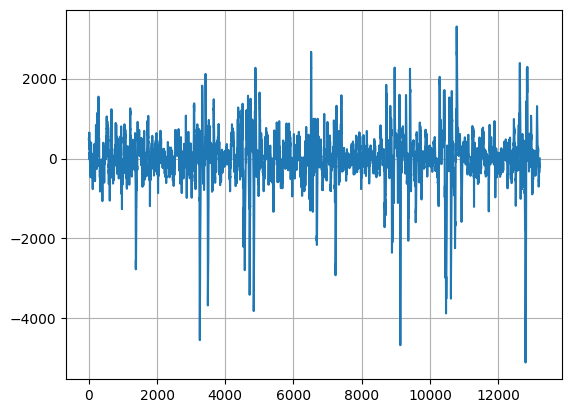

In [59]:
plt.plot(res2.resid)
plt.grid()

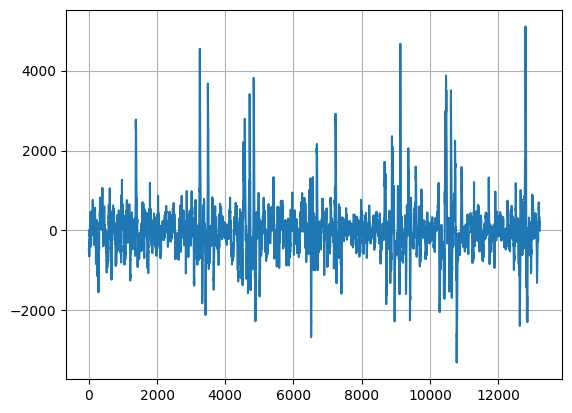

In [60]:
plt.plot(res1.seasonal +  res2.trend + res2.seasonal  - merged_df["value"][:-24*60])
plt.grid()